# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [2]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.6' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb/

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname

[cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
feynmangpu04.cluster.local


In [16]:
model = FieldLevelModel(**default_config | {'evolution': 'kaiser'})

truth = {'Omega_m': 0.3, 
        'sigma8': 0.8, 
        'b1': 0.,
        'b2':0., 
        'bs2':0., 
        'bn2': 0.}

model.loc_fid['b1'] = 0.
truth = model.predict(samples=truth, hide_base=False, frombase=True)

In [17]:
post = jit(vmap(partial(model.kaiser_post, delta_obs=truth['obs']-1, base=True)))(jr.split(jr.key(45), 1000))
meshes = vmap(jnp.fft.irfftn)(post['init_mesh'])

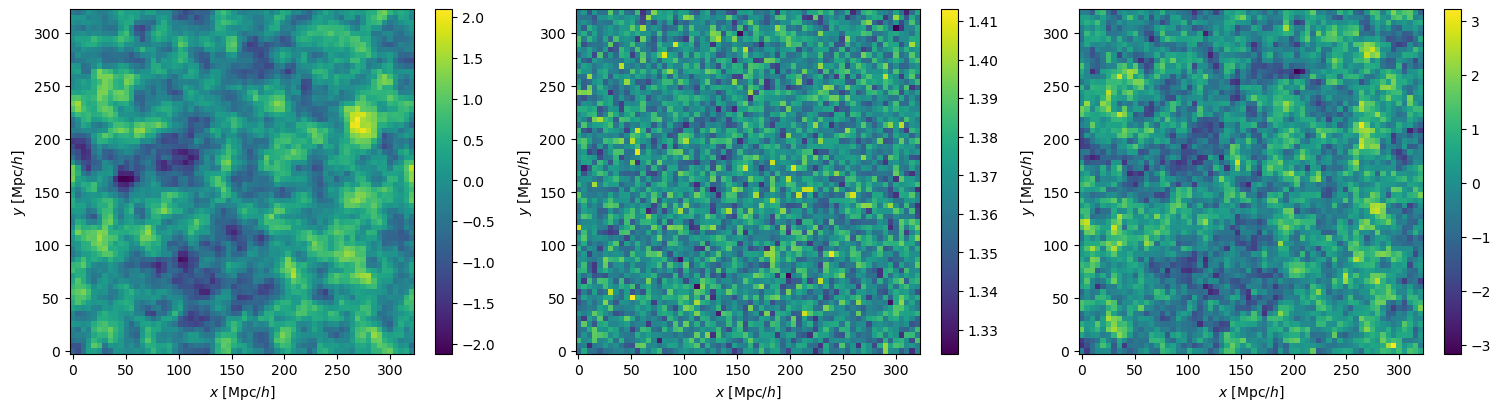

In [18]:
from montecosmo.plot import plot_mesh

sli = 0.1

plt.figure(figsize=(15, 4), layout='constrained')
plt.subplot(131)
plot_mesh(meshes.mean(0), model.box_shape, sli=sli)
plt.colorbar()

plt.subplot(132)
plot_mesh(meshes.std(0), model.box_shape, sli=sli)
plt.colorbar()

plt.subplot(133)
plot_mesh(jnp.fft.irfftn(truth['init_mesh']), model.box_shape, sli=sli)
plt.colorbar()

## Config and fiduc

In [19]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
# m, ev, lo, rsdb, pc, samp, mm
task_id = 2110241
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)
print("save path:", save_path)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)
# print("jax_enable_x64:", jconfig.read("jax_enable_x64"))

SLURM_ARRAY_TASK_ID: 2110241
True id: 2110241
save path: /feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield_norsdb/sAdjMCLMC_nc4_ns64


# CONFIG
{'a_obs': 0.5,
 'box_shape': array([160., 160., 160.]),
 'evolution': 'lpt',
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.05656854249492381},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'loc_fid': 1.0,
                    'scale': 0.5,
                    'scale_fid': 0.11313708498984762},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'loc_fid': 0.0,
                    'scale': 2.0,
                    'scale_fid': 0.05656854249492381},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\

2025-02-16 19:04:16.507159: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Saving model and truth at /feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_ao0.5_evlpt_lo1_pckaiser_obfield_norsdb/
no bias


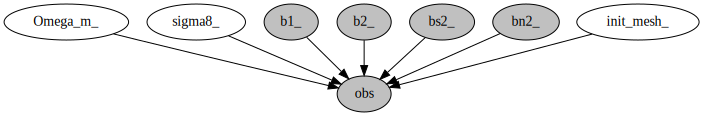

In [ ]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.3, 
            'sigma8': 0.8, 
            'b1': 1.,
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}
    
    if model.loc_fid['b1'] == 0:
        truth['b1'] = 0.

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir+"model.p")    
    pdump(truth, save_dir+"truth.p")

elif not os.path.exists(save_dir+"model.p"):
    print(f"Loading truth from {save_dir} and saving model")
    model.save(save_dir+"model.p") 
    truth = pload(save_dir+"truth.p")

else:   
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.reset()
if model.loc_fid['b1'] == 0:
    print('no bias')
    model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    # model.condition({'obs': truth['obs'], 'bn2': truth['bn2']}, frombase=True)
else:
    model.condition({'obs': truth['obs']})
model.block()
# model.render()

## Sample

### Init

# Warmupping...
Perform 1024 adaptation steps
# End warmup
Init config: MCLMCAdaptationState(L=Array([184.90400377, 184.88314007, 184.96673512, 184.93073783], dtype=float64), step_size=Array([30.89675754, 32.0934774 , 31.50344025, 32.25890664], dtype=float64), inverse_mass_matrix=Array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float64))
dict_keys(['init_mesh_']) dict_keys(['Omega_m_', 'b1_', 'b2_', 'bn2_', 'bs2_', 'init_mesh_', 'sigma8_'])
no bias
dict_keys(['Omega_m_', 'sigma8_', 'init_mesh_']) 

no bias


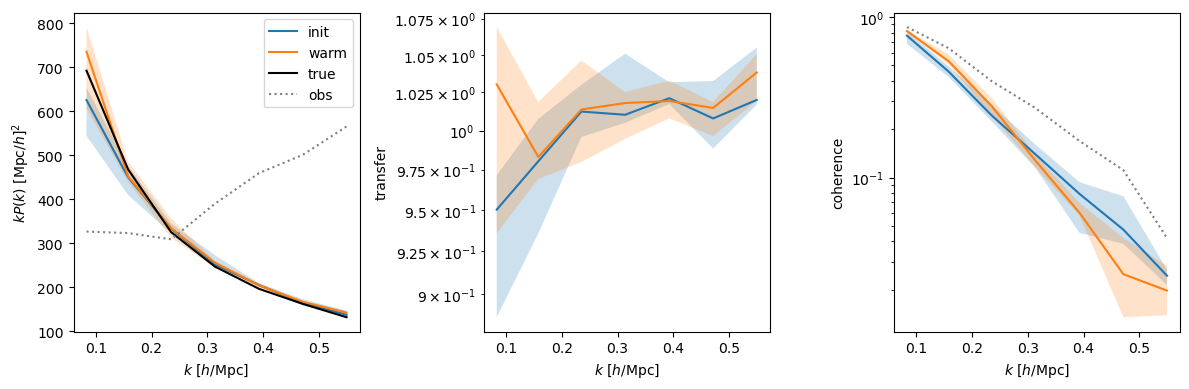

In [ ]:
continue_run = False
if continue_run:
    pass
else:
    model.reset()
    model.condition({'obs': truth['obs']} | model.loc_fid, frombase=True)
    model.block()

    # mcmc = get_init_mcmc(model.model, mcmc_config['n_chains'])    
    init_params_ = jit(vmap(partial(model.kaiser_post, delta_obs=truth['obs']-1)))(jr.split(jr.key(45), mcmc_config['n_chains']))
    # init_params_ = model.predict(45, samples=mcmc_config['n_chains'], hide_samp=False)
    
    if not os.path.exists(save_path+f"_init_last_state.p"):
        print("# Warmupping...")
        init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']} # NOTE: !!!!!!!
        # mcmc = sample_and_save(mcmc, save_path+'_init', 0, 0, extra_fields=['num_steps'], init_params=init_mesh_)
        # ils = mcmc.last_state.z

        from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run

        warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**12, config=None, 
                                    desired_energy_var=1e-5, diagonal_preconditioning=False)))
        state, config = warmup_fn(jr.split(jr.key(43), mcmc_config['n_chains']), init_mesh_)
        pdump(state, save_path+f"_init_last_state.p")
        pdump(config, save_path+f"_init_conf.p")
        print("# End warmup")
        print("Init config:", config)
        ils = state.position

    else:
        print("# Loading init_last_state")
        # ils = pload(save_path + "_init_last_state.p").z

        state = pload(save_path+f"_init_last_state.p")
        # config = pload(save_path+f"_init_conf.p")
        # print("Init config:", config)
        ils = state.position
    
    # ils = {k: jnp.broadcast_to(v, (mcmc_config['n_chains'], *jnp.shape(v))) for k, v in truth.items()}
    # ils = {k+'_': ils[k+'_'] for k in ['Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']}

    ################
    from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh
    mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
    kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
    kpk0 = model.spectrum(mesh0)
    kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
    kpkobs = model.spectrum(truth['obs']-1)
    
    print(ils.keys(), init_params_.keys())

    prob = 0.95
    plt.figure(figsize=(12, 4))
    plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='init')
    plot_powtranscoh(*kptcs__, fill=prob)
    plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='warm')
    plot_powtranscoh(*kptcs_, fill=prob)
    plt.subplot(131)
    plot_pow(*kpk0, 'k', label='true')
    plot_pow(*kpkobs, ':', c='grey', label='obs')
    plt.legend()
    plt.subplot(133)
    plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
    plt.tight_layout()
    plt.savefig(save_dir+f'initkai_{task_id}.png')
    # plt.savefig(f'init_glin_{task_id}.png')
    ################    
    
    if model.loc_fid['b1'] == 0:
        print('no bias')
        init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_']} | ils
        # init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_','b1_','b2_','bs2_']} | ils
    else:
        init_params_ |= ils
        # init_params_ |= mcmc.last_state.z
    print(init_params_.keys(),'\n')


model.reset()
if model.loc_fid['b1'] == 0:
    print('no bias')
    model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    # model.condition({'obs': truth['obs'], 'bn2': truth['bn2']}, frombase=True)
else:
    model.condition({'obs': truth['obs']})
model.block()

### Warmup and Run

In [ ]:
from tqdm import tqdm
if mcmc_config['sampler'] in ['NUTS', 'HMC']:
    mcmc = get_mcmc(model.model, mcmc_config)
    if continue_run:
        print(f"{jnp.result_type(True)=}") # HACK: why is it working?!!
        mcmc.num_warmup = 0
        mcmc.post_warmup_state = pload(save_path + "_last_state.p")
        start = 21 ###############
        end = start + mcmc_config['n_runs'] - 1
        mcmc_runned = sample_and_save(mcmc, save_path, start, end, rng=44, extra_fields=['num_steps'])

    else:
        mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)
       

elif mcmc_config['sampler'] in ['NUTSwG','NUTSwG2']:
    from montecosmo.samplers import nutswg_init, get_nutswg_warm, get_nutswg_run
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']
    step_fn, init_fn, conf, init_state_fn = nutswg_init(model.logpdf)

    warmup_fn = jit(vmap(get_nutswg_warm(model.logpdf, conf, mcmc_config['n_samples'], progress_bar=False)))
    state = vmap(init_state_fn)(init_params_)

    samples, infos, state, conf = warmup_fn(jr.split(jr.key(43), n_chains), state)
    print("conf:", conf,
            "\n\ninfos:", infos, '\n#################\n')
    jnp.savez(save_path+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    pdump(state, save_path+f"_last_state.p")
    pdump(conf, save_path+'_conf.p'), pdump(tree.map(jnp.mean, infos), save_path+'_infos.p')

    # conf = pload(save_path+'_conf.p')
    # state = pload(save_path+'_last_state.p')
    
    run_fn = jit(vmap(get_nutswg_run(model.logpdf, step_fn, init_fn, n_samples, progress_bar=False)))
    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, end+1)):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        samples, infos, state = run_fn(jr.split(run_key, n_chains), state, conf)
        print("infos:", tree.map(lambda x: jnp.mean(x, 1), infos))
        jnp.savez(save_path+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(state, save_path+f"_last_state.p")


elif mcmc_config['sampler'] == 'MCLMC':
    from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']
    from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState

    if model.precond=='direct':
        desvar = 1e-7
        evpess = 1e3
    elif model.precond=='fourier':
        desvar = 3e-7
        evpess = 1e3
    elif model.precond=='kaiser':
        desvar = 1e-6
        evpess = 1e3
    elif model.precond=='kaiser_dyn':
        desvar = 3e-6
        evpess = 1e3
    n_steps = 2**14
    logdf = jit(model.logpdf)
    print(f"### {model.precond=}, {desvar=}, {evpess=}, {n_steps=}")
    warmup_fn = jit(vmap(get_mclmc_warmup(logdf, n_steps=n_steps, config=None, 
                                        desired_energy_var=desvar, diagonal_preconditioning=mcmc_config['mm'])))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), init_params_)
    # state = pload(save_path+f"_last_state.p")
    # config = pload(save_path+f"_conf.p")
    print(config)

    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=2/5 * evpess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)

    pdump(state, save_path+f"_0_last_state.p")
    pdump(config, save_path+f"_conf.p")
    
    print(config)
    thinning = 16
    run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=thinning, progress_bar=False)))

    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, n_runs + start)):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        state, samples = run_fn(jr.split(run_key, n_chains), state, config)
        
        print("MSE per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
        jnp.savez(save_path+f"_{i_run}.npz", **samples)
        pdump(state, save_path+f"_last_state.p")



elif mcmc_config['sampler'] == 'aMCLMC':
    from montecosmo.samplers import get_adj_mclmc_warmup, get_adj_mclmc_run
    n_samples, n_runs, n_chains = mcmc_config['n_samples'], mcmc_config['n_runs'], mcmc_config['n_chains']
    from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState

    n_steps = 2**6
    logdf = jit(model.logpdf)
    print(f"### {model.precond=}, {n_steps=}")
    warmup_fn = jit(vmap(get_adj_mclmc_warmup(logdf, n_steps=n_steps, config=None, 
                                            diagonal_preconditioning=mcmc_config['mm'])))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), init_params_)
    # state = pload(save_path+f"_last_state.p")
    # config = pload(save_path+f"_conf.p")
    print(config)

    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=jnp.median(config.L), 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)

    pdump(state, save_path+f"_0_last_state.p")
    pdump(config, save_path+f"_conf.p")
    
    print(config)
    thinning = 1
    run_fn = jit(vmap(get_adj_mclmc_run(model.logpdf, n_samples, thinning=thinning, progress_bar=False)))

    start = 1 ######
    end = start + n_runs - 1
    key = jr.key(42)
    for i_run in tqdm(range(start, n_runs + start)):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        state, samples = run_fn(jr.split(run_key, n_chains), state, config)
        
        print("n_evals:", jnp.mean(samples['n_evals'], 1), '\n')
        jnp.savez(save_path+f"_{i_run}.npz", **samples)
        pdump(state, save_path+f"_last_state.p")